/tmp/ipykernel_3353205/2728389459.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


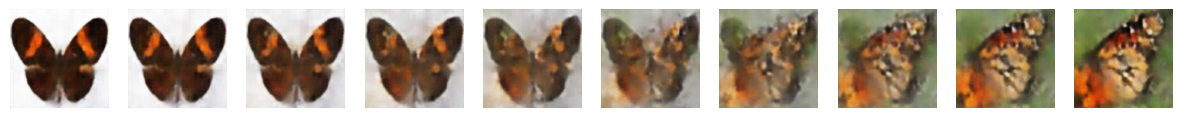

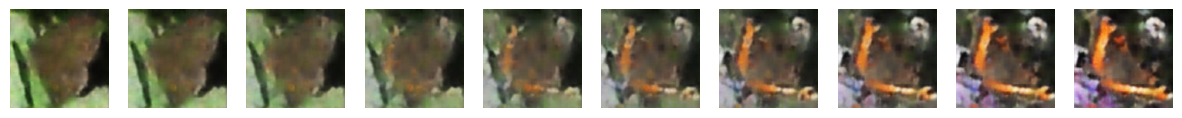

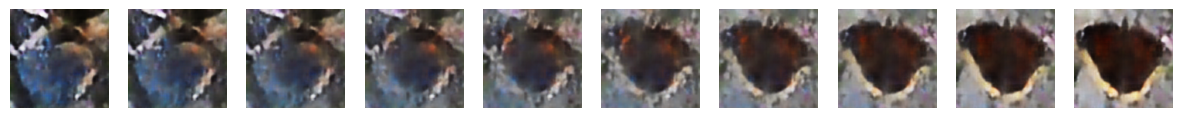

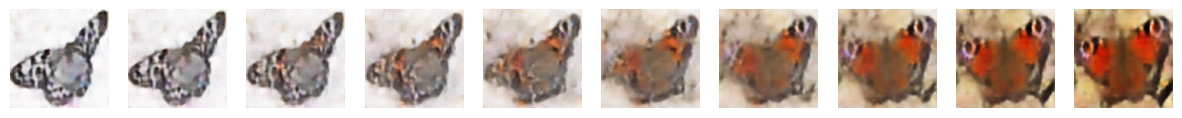

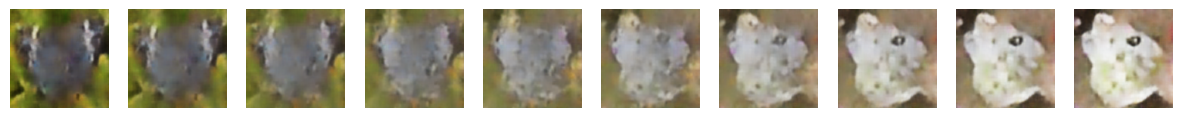

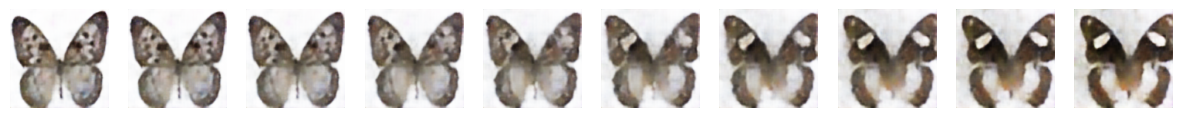

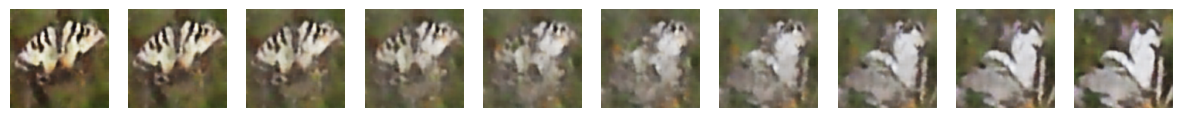

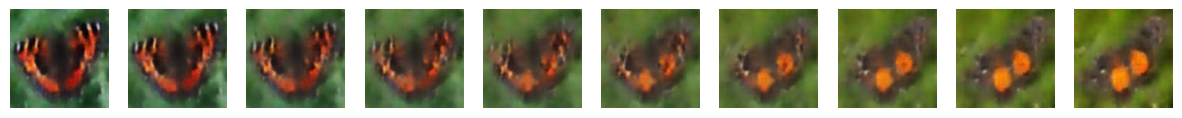

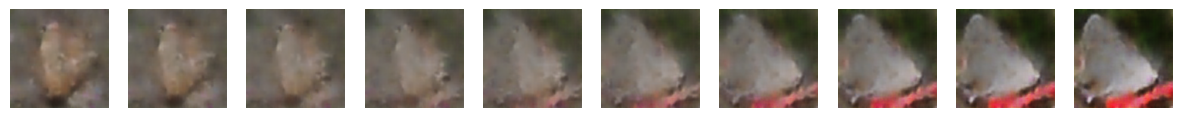

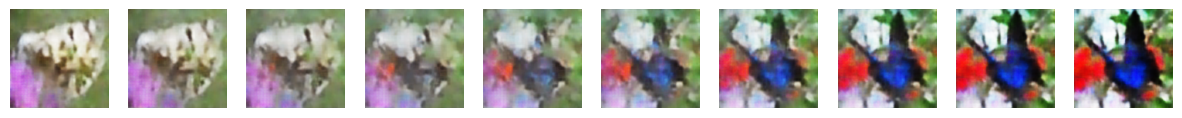

In [ ]:
def sample_image_pairs(dataloader, num_pairs=10):
    images = []
    for batch in dataloader:
        images.extend(batch['image'])  
        if len(images) >= num_pairs * 2:
            break
    image_pairs = [(images[i], images[i + 1]) for i in range(0, num_pairs * 2, 2)]
    return image_pairs

def interpolate_and_plot(model, image_pairs, num_interpolations=10):
    with torch.no_grad():
        for img1, img2 in image_pairs:
            mu1, logvar1 = model.encode(img1.unsqueeze(0).to(device))  
            mu2, logvar2 = model.encode(img2.unsqueeze(0).to(device))

            latents = []
            for t in np.linspace(0, 1, num_interpolations):
                z = mu1 * (1 - t) + mu2 * t  
                latents.append(z)

            generated_images = model.decode(torch.stack(latents).to(device)).cpu()

            fig, axes = plt.subplots(1, num_interpolations, figsize=(15, 5))
            for ax, img in zip(axes, generated_images):
                ax.imshow(img.permute(1, 2, 0).numpy())  
                ax.axis('off')
            plt.show()

image_pairs = sample_image_pairs(dataloader_butterfly_train, num_pairs=10)
model=load_model(latent_dim,'/data1/Code/Nidhi/ADRLass2/beta_0.01_vae_model.pth')
interpolate_and_plot(model, image_pairs)

# Adversarial Auto Encoder

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_fid import fid_score
from torchvision.utils import save_image
import torch.nn.functional as F
import torchvision.utils as vutils
import random

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_filepath=r"/home/vishnuja/archive/Training_set.csv" 

data_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor() ,
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

dataset = load_dataset('csv', data_files=dataset_filepath)


# Function transform the image
def transform_image(data):
    image = Image.open('/home/vishnuja/archive/train/'+data['filename'])
    data['image'] = data_transforms(image)
    return data

dataset = dataset.map(transform_image)
dataset.set_format(type='torch', columns=['image'])

dataloader_butterfly = DataLoader(dataset['train'], batch_size=128, shuffle=True, num_workers=5)



In [ ]:

def calculate_fid_butterfly(netG):
    real_idx = 0
    gen_idx = 0
    eps = 1e-10 
    resize_transform = transforms.Compose([
        transforms.Resize((299, 299)) 
    ])
        
    real_img_dir = 'real_images_butterfly_aae'
    gen_img_dir = 'generated_images_butterfly_aae'
    os.makedirs(real_img_dir, exist_ok=True)
    os.makedirs(gen_img_dir, exist_ok=True)

    def save_images(images, directory, prefix, start_idx):
        os.makedirs(directory, exist_ok=True)
        for i, img in enumerate(images):
            save_image(img, os.path.join(directory, f"{prefix}_{start_idx + i}.png"))

    for data in dataloader_butterfly:
        real_images = data['image'].to(device).cpu()
        if real_idx < 1000:  # Limit to 1000 images
            for idx, img in enumerate(real_images): 
                min_val = img.min()
                max_val = img.max()
                normalized_img = (img - min_val) / (max_val - min_val + eps)
                resized_img = resize_transform(normalized_img)
                save_images(resized_img, real_img_dir, "real", real_idx+idx)
                    
            real_idx += real_images.shape[0]
        if gen_idx < 1000:
            z = torch.randn(real_images.shape[0], latent_dim, device=device)
            generated_imgs = netG(z).cpu()
                    
            for idx, img in enumerate(generated_imgs):
                min_val = img.min()
                max_val = img.max()
                normalized_img = (img - min_val) / (max_val - min_val + eps)
                resized_img = resize_transform(normalized_img)
                save_images(resized_img, gen_img_dir, "gen", gen_idx+idx)
            gen_idx += real_images.shape[0]


    # Compute FID
    fid_value = fid_score.calculate_fid_given_paths([real_img_dir, gen_img_dir], batch_size=64, device=device, dims=2048)
    return fid_value

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
latent_dim = 128*3
learning_rate = 0.0002
epochs = 500

# Encoder 
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128*2, 4, stride=2, padding=1),
            nn.BatchNorm2d(128*2),
            nn.ReLU(),
            nn.Conv2d(128*2, 128*4, 4, stride=2, padding=1),
            nn.BatchNorm2d(128*4),
            nn.ReLU(),
            nn.Conv2d(128*4, 128*8, 4, stride=4, padding=0),
            nn.BatchNorm2d(128*8),
            nn.ReLU(),
            nn.Conv2d(128*8, 128*16, 4, stride=4, padding=0),
            nn.BatchNorm2d(128*16),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128*16, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# Decoder 
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128*16*4*4),

            nn.ReLU(),
            nn.Unflatten(1, (128*16,4,4)),
            nn.ConvTranspose2d(128*16, 128*8, 4, stride=2, padding=1),
            nn.BatchNorm2d(128*8),
            nn.ReLU(),
            nn.ConvTranspose2d(128*8, 128*4, 4, stride=2, padding=1),
            nn.BatchNorm2d(128*4),
            nn.ReLU(),
            nn.ConvTranspose2d(128*4, 128*2, 4, stride=2, padding=1),
            nn.BatchNorm2d(128*2),
            nn.ReLU(),
            nn.ConvTranspose2d(128*2, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.decoder(z).view(-1, 3, 128, 128)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(latent_dim, 128*16),

            nn.LeakyReLU(0.2,False),
            nn.Linear(128*16, 128*8),
            nn.LeakyReLU(0.2,False),
            nn.Linear(128*8, 128*4),

            nn.LeakyReLU(0.2,False),
            nn.Linear(128*4, 128*2),

            nn.LeakyReLU(0.2,False),
            nn.Linear(128*2, 128),

            nn.LeakyReLU(0.2,False),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.discriminator(z)

encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)

# Loss functions and optimizers
reconstruction_loss = nn.MSELoss()
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)
optimizer_E = optim.Adam(encoder.parameters(), lr=learning_rate) 
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)


for epoch in range(epochs):
    for batch, data in enumerate(dataloader_butterfly):
        torch.autograd.set_detect_anomaly(True)
        imgs = data['image'].to(device)

        real_labels = torch.ones(imgs.size(0), 1, device=device)
        fake_labels = torch.zeros(imgs.size(0), 1, device=device)

        # ---------------------
        #  Train (Encoder + Decoder)
        # ---------------------
        optimizer_G.zero_grad()

        z_fake = encoder(imgs)
        generated_imgs = decoder(z_fake)

        rec_loss = reconstruction_loss(generated_imgs, imgs)
        rec_loss.backward(retain_graph=True)  

        optimizer_G.step()  

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        z_real = torch.randn(imgs.size(0), latent_dim, device=device)
        d_loss_real = adversarial_loss(discriminator(z_real), real_labels)
        d_loss_fake = adversarial_loss(discriminator(z_fake.detach()), fake_labels)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        #  Train Encoder with Adversarial Loss
        # ---------------------
        optimizer_E.zero_grad()

        adv_loss = adversarial_loss(discriminator(encoder(imgs)), real_labels) 
        adv_loss.backward()

        optimizer_E.step() 

    if (epoch+1) % 100 == 0: 
        print(f"Epoch [{epoch+1}/{epochs}]  rec_loss - {rec_loss.item()}, adv_loss - {adv_loss.item()}")
        fig, axs = plt.subplots(10, 2, figsize=(10, 10))
        for data in dataloader_butterfly:
            img_orgs=data['image'].to(device)
            z = encoder(img_orgs)
            gen_imgs = decoder(z).detach().cpu()
            for i in range(10):
                    img_org=img_orgs[i].detach().cpu()
                    img_o = img_org.permute(1, 2, 0).detach().numpy()
                    min_val = img_o.min()
                    max_val = img_o.max()
                    normalized_img_o = (img_o - min_val) / (max_val - min_val)
                    img = gen_imgs[i].permute(1, 2, 0).detach().numpy()
                    min_val = img.min()
                    max_val = img.max()
                    normalized_img = (img - min_val) / (max_val - min_val)
                    
                    axs[i, 0].imshow(normalized_img_o)
                    axs[i, 0].axis('off')       
                    # Plot the image
                    axs[i, 1].imshow(normalized_img)
                    axs[i, 1].axis('off')
            break
        plt.tight_layout()
        plt.show()   
         
        z = torch.randn(100, latent_dim, device=device)
        with torch.no_grad():
            generated_img = decoder(z).detach().cpu()

        fig, axs = plt.subplots(10, 10, figsize=(10, 10))

        for i in range(10):
            for j in range(10):
                img = generated_img[i * 10 + j].permute(1, 2, 0).detach().numpy()
                min_val = img.min()
                max_val = img.max()
                normalized_img = (img - min_val) / (max_val - min_val)
                
                axs[i, j].imshow(normalized_img)
                axs[i, j].axis('off')

        plt.tight_layout()
        plt.show()
        
        fid_value = calculate_fid_butterfly(decoder)
        print(f"FID Score at epoch {epoch+1}: {fid_value}")
